<div class="alert alert-warning">
<b>LIBRARIES, CAS, AND ACTION SETS</b>
</div>

In [1]:
# Libraries
import swat
import pandas as pd
import sys
import numpy as np

# DLPy
sys.path.append('/python-dlpy')
import dlpy
from dlpy.images import ImageTable
from dlpy import Model, Sequential
from dlpy.layers import * 
from dlpy.applications import *

In [2]:
# CAS Connection
conn = swat.CAS(host, port)

In [3]:
conn.loadactionset('Image')
conn.loadactionset('deepLearn')
conn.loadactionset('sampling')
conn.loadactionset('searchAnalytics');

NOTE: Added action set 'Image'.
NOTE: Added action set 'deepLearn'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'searchAnalytics'.


In [4]:
# Setup a CAS Library
conn.addcaslib(activeonadd=True,
                     datasource={'srctype':'path'},
                     name='retaildata',
                     path='/cas/DeepLearn/anviol/data/',
                     subdirectories=True);

NOTE: 'retaildata' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'retaildata'.


<div class="alert alert-warning">
<b>LOAD AND PREVIEW DATA</b>
</div>

In [5]:
conn.loadimages(path='retailMultiLabel',
                casout=dict(name='retail_data', replace=True),
                caslib='retaildata',
                labellevels=-1, # Pull Subdirectories as Labels
                recurse=True)

NOTE: Loaded 2167 images from /cas/DeepLearn/anviol/data/retailMultiLabel into Cloud Analytic Services table retail_data.


+ Elapsed: 2.69s, user: 0.684s, sys: 0.65s, mem: 73.1mb

In [6]:
conn.columninfo('retail_data')

,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,_image_,1,varbinary,6240426,6240426,0,0
1,_size_,2,int64,8,12,0,0
2,_path_,3,varchar,69,69,0,0
3,_label_,4,varchar,11,11,0,0
4,_type_,5,char,3,3,0,0
5,_id_,6,int64,8,12,0,0


In [7]:
conn.CASTable('retail_data').head()

,_image_,_size_,_path_,_label_,_type_,_id_
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,244278,/cas/DeepLearn/anviol/data/retailMultiLabel/re...,red_dress,jpg,1
1,b'\xff\xd8\xff\xe1\x1a\x08Exif\x00\x00MM\x00*\...,146577,/cas/DeepLearn/anviol/data/retailMultiLabel/re...,red_dress,jpg,2
2,b'\xff\xd8\xff\xe1\x10\x04Exif\x00\x00II*\x00\...,136929,/cas/DeepLearn/anviol/data/retailMultiLabel/re...,red_dress,jpg,3
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,126668,/cas/DeepLearn/anviol/data/retailMultiLabel/re...,red_dress,jpg,4
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,179679,/cas/DeepLearn/anviol/data/retailMultiLabel/re...,red_dress,jpg,5


In [8]:
conn.CASTable('retail_data').freq(inputs='_label_')

,Column,CharVar,FmtVar,Level,Frequency
0,_label_,black_jeans,black_jeans,1,344.0
1,_label_,blue_dress,blue_dress,2,386.0
2,_label_,blue_jeans,blue_jeans,3,356.0
3,_label_,blue_shirt,blue_shirt,4,369.0
4,_label_,red_dress,red_dress,5,380.0
5,_label_,red_shirt,red_shirt,6,332.0


<div class="alert alert-warning">
<b>DATA PREPARATION FOR MULTIPLE OUTPUTS</b>
</div>

In [9]:
retail_data = conn.CASTable('retail_data')

In [10]:
# Create Dummies Table from _label_ Column
dummy = pd.get_dummies(retail_data['_label_'])

# Preview
dummy.head()

,black_jeans,blue_dress,blue_jeans,blue_shirt,red_dress,red_shirt
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,1,0
3,0,0,0,0,1,0
4,0,0,0,0,1,0


In [11]:
# Create Lower Level Labels for Multiple Labels

# Colors
black = dummy['black_jeans']
blue  = dummy[['blue_dress', 'blue_jeans', 'blue_shirt']].max(axis=1)
red   = dummy[['red_dress', 'red_shirt']].max(axis=1)

# Product
jeans = dummy[['black_jeans', 'blue_jeans']].max(axis=1)
dress = dummy[['blue_dress', 'red_dress']].max(axis=1)
shirt = dummy[['blue_shirt', 'red_shirt']].max(axis=1)

In [12]:
# Concat Series into a Dataframe
labels_df = pd.DataFrame(pd.concat([black, blue, red, jeans, dress, shirt], axis=1))

# DataFrame Column Names
labels_df.columns = ['black', 'blue', 'red', 'jeans', 'dress', 'shirt']

# Add Back Label Column
labels_df['_label_'] = pd.Series(retail_data['_label_'])

In [13]:
labels_df.head()

,black,blue,red,jeans,dress,shirt,_label_
0,0,0,1,0,1,0,red_dress
1,0,0,1,0,1,0,red_dress
2,0,0,1,0,1,0,red_dress
3,0,0,1,0,1,0,red_dress
4,0,0,1,0,1,0,red_dress


In [14]:
# Create a Unique Lookup Table for Table Joining
annotation_tbl = labels_df
annotation_tbl = annotation_tbl.drop_duplicates()

In [15]:
annotation_tbl

,black,blue,red,jeans,dress,shirt,_label_
0,0,0,1,0,1,0,red_dress
380,0,1,0,0,0,1,blue_shirt
749,0,0,1,0,0,1,red_shirt
1081,0,1,0,0,1,0,blue_dress
1467,1,0,0,1,0,0,black_jeans
1811,0,1,0,1,0,0,blue_jeans


In [16]:
# Upload Dataframe to CAS
conn.upload_frame(annotation_tbl, casout=dict(name='annotation_tbl', replace=True));

NOTE: Cloud Analytic Services made the uploaded file available as table ANNOTATION_TBL in caslib retaildata.
NOTE: The table ANNOTATION_TBL has been created in caslib retaildata from binary data uploaded to Cloud Analytic Services.


In [17]:
# Join Annotations with Image Table
retail_data_joined = conn.dlJoin(annotatedTable=dict(name='annotation_tbl'),
                                 table=dict(name='retail_data'),
                                 id='_label_',
                                 casout=dict(name='retail_data_joined', replace=True));

In [18]:
# Preview
conn.CASTable('retail_data_joined').head()

,_label_,_image_,_size_,_path_,_type_,_id_,black,blue,red,jeans,dress,shirt
0,blue_jeans,b'\xff\xd8\xff\xe1\x13\xe3Exif\x00\x00MM\x00*\...,439768,/cas/DeepLearn/anviol/data/retailMultiLabel/bl...,jpg,2161,0.0,1.0,0.0,1.0,0.0,0.0
1,blue_jeans,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,315143,/cas/DeepLearn/anviol/data/retailMultiLabel/bl...,jpg,2162,0.0,1.0,0.0,1.0,0.0,0.0
2,blue_jeans,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,246244,/cas/DeepLearn/anviol/data/retailMultiLabel/bl...,jpg,2163,0.0,1.0,0.0,1.0,0.0,0.0
3,blue_jeans,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1597180,/cas/DeepLearn/anviol/data/retailMultiLabel/bl...,png,2059,0.0,1.0,0.0,1.0,0.0,0.0
4,blue_dress,b'\xff\xd8\xff\xe1\x1a>Exif\x00\x00MM\x00*\x00...,169875,/cas/DeepLearn/anviol/data/retailMultiLabel/bl...,jpg,1281,0.0,1.0,0.0,0.0,1.0,0.0


In [19]:
# Load as Image Table with DLPy
retail_data_dlpy = dlpy.ImageTable.from_table(conn.CASTable('retail_data_joined'),
                                              image_col='_image_',
                                              label_col='_label_')

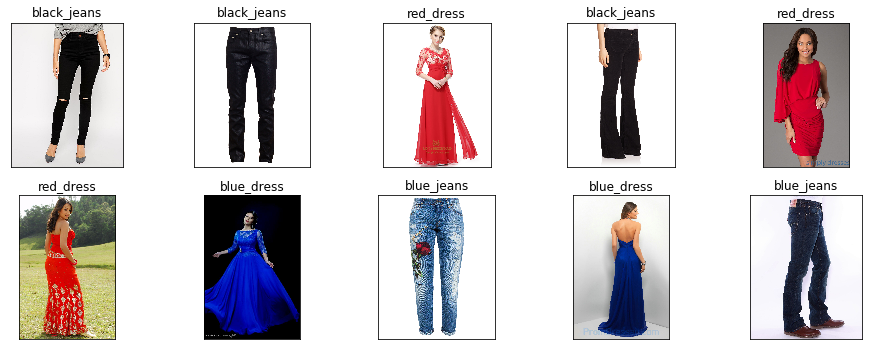

In [22]:
# Preview Images
retail_data_dlpy.show(nimages=10, ncol=5, randomize=True)

In [23]:
# Retail Column Info
retail_data_dlpy.image_summary

jpg                  2167
minWidth              313
maxWidth             5280
minHeight             277
maxHeight            7360
meanWidth         1075.22
meanHeight        1342.09
mean1stChannel    174.989
min1stChannel           0
max1stChannel         255
mean2ndChannel    166.346
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    182.342
min3rdChannel           0
max3rdChannel         255
dtype: object

In [24]:
# Resize Images to 200 x 200 and Copy Variables Over
conn.image.processimages(imagetable='retail_data_joined',
                         casout=dict(name='retail_data_resized', replace=True),
                         imagefunctions=[dict(functionoptions=dict(functiontype='resize', w=200, h=200))],
                         copyVars=['black','blue','red','jeans','dress','shirt']
                        )

NOTE: Table RETAIL_DATA_JOINED contains compressed images.
NOTE: 2165 out of 2167 images were processed successfully and saved as compressed images to the Cloud Analytic Services table retail_data_resized.


+ Elapsed: 2.04s, user: 83.4s, sys: 9.8s, mem: 167mb

In [25]:
# Double Check Image Sizes
conn.summarizeImages(table='retail_data_resized', image='_image_')

NOTE: Table RETAIL_DATA_RESIZED contains compressed images.
NOTE: 2165 out of 2165 images were scanned and results were saved to the summary table.


,Column,jpg,png,minWidth,maxWidth,minHeight,maxHeight,meanWidth,meanHeight,mean1stChannel,min1stChannel,max1stChannel,mean2ndChannel,min2ndChannel,max2ndChannel,mean3rdChannel,min3rdChannel,max3rdChannel
0,_image_,2101.0,64.0,200.0,200.0,200.0,200.0,200.0,200.0,174.861408,0.0,255.0,166.285459,0.0,255.0,182.178533,0.0,255.0


In [26]:
# Shuffle Data
retail_data_resized = conn.CASTable('retail_data_resized')

retail_data_resized.shuffle(casout=dict(name='retail_data_shuffled', replace=True, blockSize=64));

In [27]:
# Random Sample for Partition Variable
conn.srs(table=dict(name='retail_data_shuffled'),
         partind=True,
         sampPct=20,
         output=dict(casout=dict(name='retail_data_final', replace=True),
                     copyVars='ALL'));

NOTE: Using SEED=2021002485 for sampling.


In [28]:
# Preview
conn.CASTable('retail_data_final').head()

,black,blue,red,jeans,dress,shirt,_image_,_size_,_path_,_type_,_id_,_label_,_PartInd_
0,0.0,0.0,1.0,0.0,1.0,0.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,9613,/cas/DeepLearn/anviol/data/retailMultiLabel/re...,jpg,18,red_dress,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,13812,/cas/DeepLearn/anviol/data/retailMultiLabel/re...,jpg,792,red_shirt,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,13341,/cas/DeepLearn/anviol/data/retailMultiLabel/bl...,jpg,1663,black_jeans,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,9909,/cas/DeepLearn/anviol/data/retailMultiLabel/re...,jpg,258,red_dress,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,13798,/cas/DeepLearn/anviol/data/retailMultiLabel/re...,jpg,1051,red_shirt,0.0


<div class="alert alert-warning">
<b>CREATE MULTI TASK MODEL</b>
</div>

In [29]:
# Manually Create Model
model = Sequential(conn, model_table='retail_cnn')
model.add(InputLayer(3, 200, 200, offsets=retail_data_dlpy.channel_means))
model.add(Conv2d(64, 3, include_bias=False, act='identity'))
model.add(BN(act='relu'))
model.add(Pooling(2))
model.add(Conv2d(64, 3,include_bias=False, act='identity'))
model.add(BN(act='relu'))
model.add(Pooling(2))
model.add(Dense(512))
model.add(OutputLayer(n=1, act='sigmoid', error='entropy'))

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Fully-connected layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


In [30]:
model.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters
0,0,Input1,input,,,None,"(200, 200, 3)","(0, 0)"
1,1,Convo.1,convo,"(3, 3)",1,Identity,"(200, 200, 64)","(1728, 0)"
2,2,B.N.1,batchnorm,,,Relu,"(200, 200, 64)","(0, 128)"
3,3,Pool1,pool,"(2, 2)",2,Max,"(100, 100, 64)","(0, 0)"
4,4,Convo.2,convo,"(3, 3)",1,Identity,"(100, 100, 64)","(36864, 0)"
5,5,B.N.2,batchnorm,,,Relu,"(100, 100, 64)","(0, 128)"
6,6,Pool2,pool,"(2, 2)",2,Max,"(50, 50, 64)","(0, 0)"
7,7,F.C.1,fc,"(160000, 512)",,Relu,512,"(81920000, 0)"
8,8,Output1,output,"(512, 1)",,Sigmoid,1,"(512, 1)"
9,,,,,,,,81959361


In [31]:
# Add 5 More Additional Output Layers (6 Classes Total)
srcname='F.C.1'

conn.addLayer(model='retail_cnn', name='Output2', layer=dict(type='output', act='sigmoid', error='entropy'), 
           srcLayers=srcname, replace=True)

conn.addLayer(model='retail_cnn', name='Output3', layer=dict(type='output', act='sigmoid', error='entropy'), 
           srcLayers=srcname, replace=True)

conn.addLayer(model='retail_cnn', name='Output4', layer=dict(type='output', act='sigmoid', error='entropy'), 
           srcLayers=srcname, replace=True)

conn.addLayer(model='retail_cnn', name='Output5', layer=dict(type='output', act='sigmoid', error='entropy'), 
           srcLayers=srcname, replace=True)

conn.addLayer(model='retail_cnn', name='Output6', layer=dict(type='output', act='sigmoid', error='entropy'), 
           srcLayers=srcname, replace=True)

,casLib,Name,Rows,Columns,casTable
0,retaildata,retail_cnn,175,5,"CASTable('retail_cnn', caslib='retaildata')"


In [32]:
# View Last Added Layer for Check
conn.fetch(table=dict(name='retail_cnn', where='_dllayerid_ = 13'))

,_DLKey0_,_DLKey1_,_DLChrVal_,_DLNumVal_,_DLLayerID_
0,output6,outputopts.n,n,0.0,13.0
1,output6,outputopts.truncfact,truncfact,0.0,13.0
2,output6,outputopts.std,std,1.0,13.0
3,output6,outputopts.target_std,target_std,2.0,13.0
4,output6,outputopts.mean,mean,0.0,13.0
5,output6,outputopts.init,Xavier,1.0,13.0
6,output6,outputopts.noFullConnect,noFullConnect,0.0,13.0
7,output6,outputopts.error,Entropy,4.0,13.0
8,output6,outputopts.act,Logistic,2.0,13.0
9,output6,layertype,Output Layer,5.0,13.0


<div class="alert alert-warning">
<b>MODEL TRAINING</b>
</div>

In [33]:
# Setup Optimization
optimizer = dict(seed=13309,
                 algorithm=dict(method='momentum',
                                  clipgradmin=-1000,
                                  clipgradmax=1000,
                                  learningRatePolicy='step',
                                  gamma=0.1,
                                  stepSize=15,
                                  learningRate=0.001),
                 maxEpochs=60,
                 miniBatchSize=16,
                 regL2=0.0001, 
                 loglevel=2
                )

# Train Model
model_train = conn.dlTrain(table=dict(name='retail_data_final', where='_PartInd_=0.0'),
                           optimizer=optimizer,
                           modelWeights=dict(name='retail_modelweights', replace=True),
                           modelTable='retail_cnn',
                           dataSpecs=[{'type':'IMAGE', 'layer':'Input1', 'data':'_image_'},
                                      {'type':'numericnominal', 'layer':'output1', 'data':'black'},
                                      {'type':'numericnominal', 'layer':'output2', 'data':'blue'},
                                      {'type':'numericnominal', 'layer':'output3', 'data':'red' },
                                      {'type':'numericnominal', 'layer':'output4', 'data':'jeans'},
                                      {'type':'numericnominal', 'layer':'output5', 'data':'dress'},
                                      {'type':'numericnominal', 'layer':'output6', 'data':'shirt'}
                                     ],
                           recordSeed=54124,
                           seed=1236,
                           nthreads=32
                          )

NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 81962438.
NOTE:  The approximate memory cost is 41627.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       2.12 (s).
NOTE:  The total number of threads on each worker is 32.
NOTE:  The total mini-batch size per thread on each worker is 16.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 512.
NOTE:  Number of output layers (including regression and classification tasks) is   6.
NOTE:  Number of keypoints layers is   0.
NOTE:  Number of detection layers is   0.
NOTE:  Number of segmentation layers is   0.
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Layer ID:   8 Name: output1 Type: Output Layer
NOTE:  Target variable: black
NOTE:  Layer ID:   9 Name: output2 Type: Output Layer
NOTE:  Target variable: blue
NOTE:  Layer ID:  10 Name: output3 Type: Output Layer
NOTE:  Target variable: red
NO

In [34]:
# View Last 10 Epochs
model_train.OptIterHistory.tail(n=10)

,Epoch,LearningRate,Loss,FitError,L2Norm
50,50.0,0.000001,0.052353,0.006695,0.034037
51,51.0,0.000001,0.050357,0.007601,0.034037
52,52.0,0.000001,0.045863,0.005829,0.034037
53,53.0,0.000001,0.048259,0.005829,0.034037
54,54.0,0.000001,0.052592,0.006730,0.034037
55,55.0,0.000001,0.055289,0.008099,0.034037
56,56.0,0.000001,0.050752,0.006640,0.034037
57,57.0,0.000001,0.053066,0.007355,0.034037
58,58.0,0.000001,0.044902,0.005456,0.034037
59,59.0,0.000001,0.048970,0.006350,0.034037


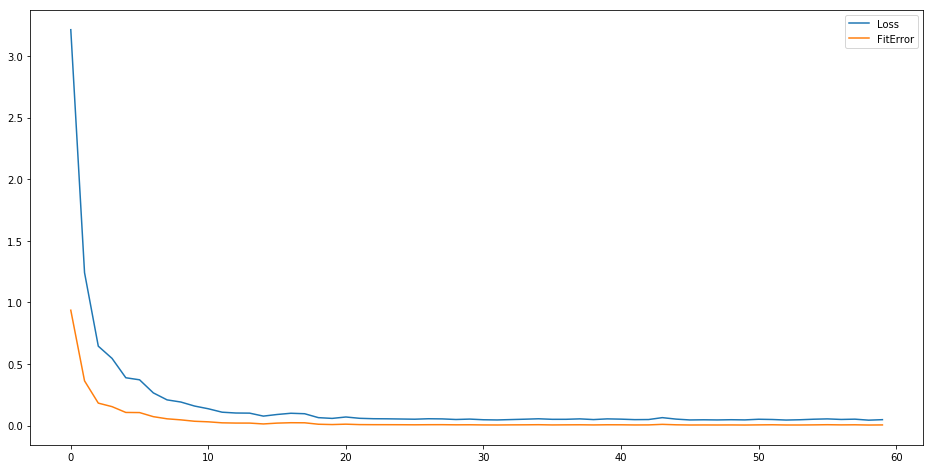

In [35]:
# View Train History
model_train.OptIterHistory[['Loss','FitError']].plot(figsize=(16,8));

<div class="alert alert-warning">
<b>MODEL SCORING AND RESULTS</b>
</div>

In [36]:
# Score Test Data
conn.dlScore(model = 'retail_cnn',
             table = dict(name='retail_data_final', where= '_PartInd_=1.0'),
             initWeights = 'retail_modelweights', 
             copyVars = ['_id_','_size_','_type_','_path_','_image_','black','blue','red','jeans','dress', 'shirt'],
             encodeName = True,
             casout = dict(name='scored_results', replace=True))

NOTE: Due to data distribution, miniBatchSize has been limited to 7.


[ScoreInfo]

                                Descr         Value
 0        Number of Observations Read           433
 1        Number of Observations Used           433
 2  Mean Squared Error (output1,   8)      0.012799
 3  Mean Squared Error (output2,   9)      0.011125
 4  Mean Squared Error (output3,  10)      0.000043
 5  Mean Squared Error (output4,  11)        0.0155
 6  Mean Squared Error (output5,  12)      0.031387
 7  Mean Squared Error (output6,  13)      0.034877
 8                         Loss Error       0.41585

[OutputCasTables]

        casLib            Name  Rows  Columns  \
 0  retaildata  scored_results   433       17   
 
                                           casTable  
 0  CASTable('scored_results', caslib='retaildata')  

+ Elapsed: 3.14s, user: 104s, sys: 7.19s, mem: 1.62e+04mb

In [37]:
# Get Results Table
res_table = conn.fetch(table='scored_results',
                       fetchVars=['_id_', 'black','blue','red','jeans','dress','shirt', \
                                  'P_black','P_blue','P_red','P_jeans','P_dress','P_shirt'],
                       to=2165,
                       maxrows=2165)

In [38]:
# Results Table Shape
res_table['Fetch'].shape

(433, 13)

In [39]:
# Convert Results Table to Pandas Dataframe and Preview
res_table = pd.DataFrame(res_table['Fetch'])
res_table.head()

,_id_,black,blue,red,jeans,dress,shirt,P_black,P_blue,P_red,P_jeans,P_dress,P_shirt
0,1531.0,1.0,0.0,0.0,1.0,0.0,0.0,6.957099e-01,0.248328,8.040622e-06,9.999928e-01,0.000013,0.000015
1,560.0,0.0,1.0,0.0,0.0,0.0,1.0,2.321768e-19,1.000000,1.000658e-19,6.866837e-09,0.000056,0.999995
2,569.0,0.0,1.0,0.0,0.0,0.0,1.0,1.122054e-13,1.000000,2.038486e-16,1.684268e-06,0.016231,0.992341
3,664.0,0.0,1.0,0.0,0.0,0.0,1.0,1.411729e-10,1.000000,1.531935e-10,5.723267e-04,0.029708,0.958473
4,2163.0,0.0,1.0,0.0,1.0,0.0,0.0,2.265372e-06,1.000000,1.319068e-07,8.981584e-01,0.026805,0.031507


In [40]:
# Set Probabilities to Binary Classification
res_table['pred_black'] = 0
res_table['pred_blue'] = 0
res_table['pred_red'] = 0
res_table['pred_jeans'] = 0
res_table['pred_dress'] = 0
res_table['pred_shirt'] = 0

res_table.loc[res_table['P_black'] >= 0.5, 'pred_black'] = 1
res_table.loc[res_table['P_blue'] >= 0.5, 'pred_blue'] = 1
res_table.loc[res_table['P_red'] >= 0.5, 'pred_red'] = 1
res_table.loc[res_table['P_jeans'] >= 0.5, 'pred_jeans'] = 1
res_table.loc[res_table['P_dress'] >= 0.5, 'pred_dress'] = 1
res_table.loc[res_table['P_shirt'] >= 0.5, 'pred_shirt'] = 1

In [41]:
# Confusion Matrix of Test Data For Each Class
display(pd.crosstab(res_table['black'],res_table['pred_black']))
display(pd.crosstab(res_table['blue'],res_table['pred_blue']))
display(pd.crosstab(res_table['red'],res_table['pred_red']))
display(pd.crosstab(res_table['jeans'],res_table['pred_jeans']))
display(pd.crosstab(res_table['dress'],res_table['pred_dress']))
display(pd.crosstab(res_table['shirt'],res_table['pred_shirt']))

pred_black,0,1
black,,
0.0,351,2
1.0,5,75


pred_blue,0,1
blue,,
0.0,222,4
1.0,2,205


pred_red,0,1
red,,
0.0,287,0
1.0,0,146


pred_jeans,0,1
jeans,,
0.0,290,5
1.0,3,135


pred_dress,0,1
dress,,
0.0,265,4
1.0,15,149


pred_shirt,0,1
shirt,,
0.0,292,10
1.0,8,123


In [42]:
# Save Out Final Data, Model Weights, and Scored Test Data
conn.save(table='retail_data_final', name="retail_data_final.sashdat", replace=True, caslib='retaildata')
conn.save(table='retail_modelweights', name="retail_modelweights.sashdat", replace=True, caslib='retaildata')
conn.save(table='scored_results', name="retail_scored_results.sashdat", replace=True, caslib='retaildata');

NOTE: Cloud Analytic Services saved the file retail_data_final.sashdat in caslib retaildata.
NOTE: Cloud Analytic Services saved the file retail_modelweights.sashdat in caslib retaildata.
NOTE: Cloud Analytic Services saved the file retail_scored_results.sashdat in caslib retaildata.


In [43]:
# Set Head of Results to a CAS Table for Easy Plotting Later
samp_5_table = conn.CASTable('scored_results').head()

In [44]:
# Create New Label by Concatenating Probs
samp_5_table['_label_'] = "Black: " + round(samp_5_table["P_black"],6).map(str) + \
                          ", Blue: " + round(samp_5_table["P_blue"],6).map(str) + \
                          ", Red: " + round(samp_5_table["P_red"],6).map(str) + \
                          ", Jeans: " + round(samp_5_table["P_jeans"],6).map(str) + \
                          ", Dress: " + round(samp_5_table["P_dress"],6).map(str) + \
                          ", Shirt: " + round(samp_5_table["P_shirt"],6).map(str)

In [45]:
# Upload Dataframe to CAS
conn.upload_frame(samp_5_table, casout=dict(name='samp_5_table', replace=True));

NOTE: Cloud Analytic Services made the uploaded file available as table SAMP_5_TABLE in caslib retaildata.
NOTE: The table SAMP_5_TABLE has been created in caslib retaildata from binary data uploaded to Cloud Analytic Services.


In [76]:
# Filter 2nd Image Table (Need Image Column in Certain Type for Plotting in DLPy)
samp_5_table_image = conn.CASTable(name='retail_data_final', where='_id_ in (1531.0, 560.0, 569.0, 664.0, 2163.0)')

In [77]:
# Save Data to CAS
conn.partition(table=samp_5_table_image, casout=dict(name='samp_5_table_image', replace=True));

In [78]:
# Join Small 2 Tables for Plotting
conn.searchJoin(leftTable=dict(table='samp_5_table', 
                            columns=[dict(isKey=True, name='_path_'),
                                     dict(name='_id_'),
                                     dict(name='_label_')
                                    ]),
                rightTable=dict(table='samp_5_table_image',
                             columns=[dict(isKey=True, name='_path_'),
                                      dict(name='_image_')
                                    ]),
                joinType = 'inner',
                casout = dict(name='plot_image_table', replace=True)
               );

In [79]:
# Load as Image Table with DLPy
retail_data_score_results = ImageTable.from_table(conn.CASTable('plot_image_table'),
                                                  image_col='_image_',
                                                  label_col='_label_')

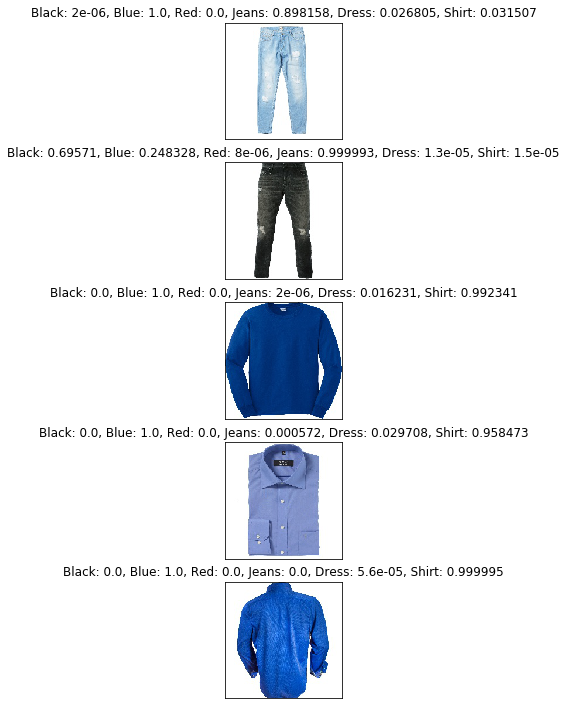

In [80]:
# Preview Scored Images
retail_data_score_results.show(nimages=5, ncol=1, figsize=(10,15))